# CNN 手写数字辨识

### Load data

In [1]:
import torch
import numpy as np
import torchvision

log_interval = 10
batch_size_train = 64
batch_size_test = 1000
n_epochs = 3

# disable cuDNN nondeterministic algorithms
torch.backends.cudnn.enabled = False

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Desktop', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train,
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Desktop', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Show img

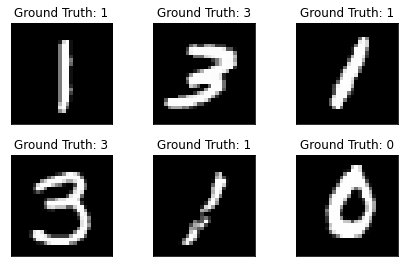

In [2]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

### Build Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        # 1 * 28 * 28
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 12 * 12 * 10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # 4 * 4 * 20
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = NNModel()
opt = optim.Adam(model.parameters())

### Define Train and Test function

In [4]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [5]:
def train(epoch):
    print("Begin train model...")
    print('iter,\tloss,\tacc')
    for batch_idx, (data, target) in enumerate(train_loader):
        y_hat = model(data)
        loss = F.nll_loss(y_hat,target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [6]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

### Run Model

In [7]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/Users/jackjun/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2299, Accuracy: 979/10000 (10%)

Begin train model...
iter,	loss,	acc
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318163
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.068517
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.548782
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.952835
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.855975
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.731687
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.293739
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.690712
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.309474
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.382205
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.285501
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.309294
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.212378
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.357615
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.272600
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.207406
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.164753
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.226708
Train Epoch: 1 [11520/60000 (19%)]	

Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.165670
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.018249
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.130019
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.029168
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.114803
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.022725
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.090585
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.034631
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.067426
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.030967
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.062193
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.023844
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.174856
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.018093
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.023894
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.083616
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.233550
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.034632
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.098401
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.055385


### Evaluating the Model's Performance

Text(0, 0.5, 'negative log likelihood loss')

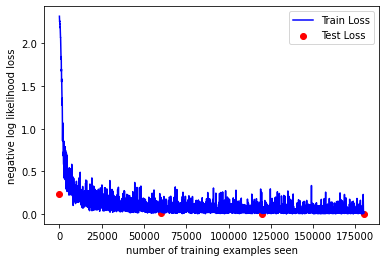

In [8]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### Save Model State

In [9]:
torch.save(model.state_dict(), './cnn.model')